## 1. Business Understanding

#### The Aim of Analysis
This study aims to search for the elements which effects WINE QUALITY by using multiclass  decision classification methods such as Support Vector Machines, K-NN, Logistic Regression, Softmax, Confusion Matrix, Accuracy, Precision, Specificity, F1 Score, ROC/AUC, Logarithmic Loss, Cross Validation, K-Fold Cross Validation, Grid Search, SMOTE 

# 2. Data Understanding

#### General Information of the Data
**Type:** Two types of wines such as red wine and white wine.<br>
**Fixed acidity:** Fixed acids include tartaric, malic, citric, and succinic acids which are found in grapes (except succinic).Acids are one of the fundamental properties of wine and contribute greatly to the taste of the wine, Acidity in food and drink tastes tart and zesty. Tasting acidity is also sometimes confused with alcohol. Wines with higher acidity feel lighter-bodied because they come across as “spritzy”. Reducing acids significantly might lead to wines tasting flat. If you prefer a wine that is richer and rounder, you enjoy slightly less acidity.<br>
**Volatile acidity:** These acids are to be distilled out from the wine before completing the production process. It is primarily constituted of acetic acid though other acids like lactic, formic and butyric acids might also be present. Excess of volatile acids are undesirable and lead to unpleasant flavour.<br>
**Citric acid:** This is one of the fixed acids which gives a wine its freshness. Usually most of it is consumed during the fermentation process and sometimes it is added separately to give the wine more freshness.<br>
**Residual sugar:** This typically refers to the natural sugar from grapes which remains after the fermentation process stops, or is stopped.<br>
**Chlorides:** Chloride concentration in the wine is influenced by terroir and its highest levels are found in wines coming from countries where irrigation is carried out using salty water or in areas with brackish terrains.<br>
**Free sulfur dioxide:** This is the part of the sulphur dioxide that when added to a wine is said to be free after the remaining part binds. Winemakers will always try to get the highest proportion of free sulphur to bind. They are also known as sulfites and too much of it is undesirable and gives a pungent odour.<br>
**Total sulfur dioxide:** This is the sum total of the bound and the free sulfur dioxide. This is mainly added to kill harmful bacteria and preserve quality and freshness. There are usually legal limits for sulfur levels in wines and excess of it can even kill good yeast and give out undesirable odour.<br>
**Density:** This can be represented as a comparison of the weight of a specific volume of wine to an equivalent volume of water. It is generally used as a measure of the conversion of sugar to alcohol.<br> 
**pH:** Also known as the potential of hydrogen, this is a numeric scale to specify the acidity or basicity the wine. Fixed acidity contributes the most towards the pH of wines. You might know, solutions with a pH less than 7 are acidic, while solutions with a pH greater than 7 are basic. With a pH of 7, pure water is neutral. Most wines have a pH between 2.9 and 3.9 and are therefore acidic.<br>
**Sulphates:** These are mineral salts containing sulfur. Sulphates are to wine as gluten is to food. They are a regular part of the winemaking around the world and are considered essential. They are connected to the fermentation process and affects the wine aroma and flavour.<br> 
**Alcohol:** It's usually measured in % vol or alcohol by volume (ABV).<br>
**Quality:** Wine experts graded the wine quality between 0 (very bad) and 10 (very excellent). The eventual quality score is the median of at least three evaluations made by the same wine experts.<br>

#### Importing Packages

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy.stats import norm 
from scipy.stats.mstats import winsorize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pylab.rcParams[ 'figure.figsize' ] = 6 , 4

#### Getting Data

In [2]:
df = pd.read_csv('winequalityN.csv')
df = pd.DataFrame(df)
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


#### About data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


#### Switching Column Names into a suitable format

In [4]:
print(*df.columns, sep='\n')

type
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality


In [5]:
df.columns = ('type', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality')

#### First 5 rows

In [6]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Looking NAN values with heatmap

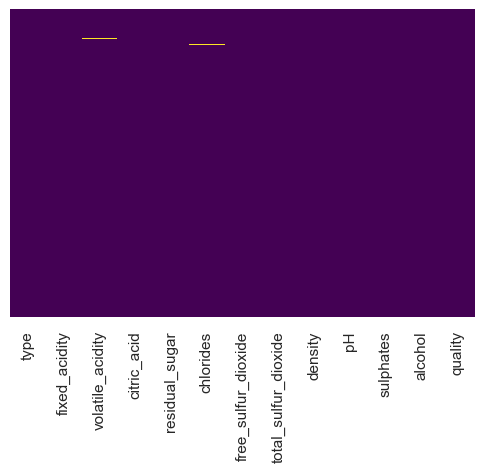

In [150]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
sns.set(font_scale=1);

#### Checking for NULL Values

In [8]:
Sum = df.isnull().sum()
Percentage = (df.isnull().sum()/df.isnull().count())*100
pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

,Sum,Percentage
type,0,0.000000
fixed_acidity,10,0.153917
volatile_acidity,8,0.123134
citric_acid,3,0.046175
residual_sugar,2,0.030783
chlorides,2,0.030783
free_sulfur_dioxide,0,0.000000
total_sulfur_dioxide,0,0.000000
density,0,0.000000
pH,9,0.138525


In [9]:
corr_matrix = df.corr()
corr_list = corr_matrix.quality.abs().sort_values(ascending=False).index[0:]

In [10]:
corr_list

Index(['quality', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH'],
      dtype='object')

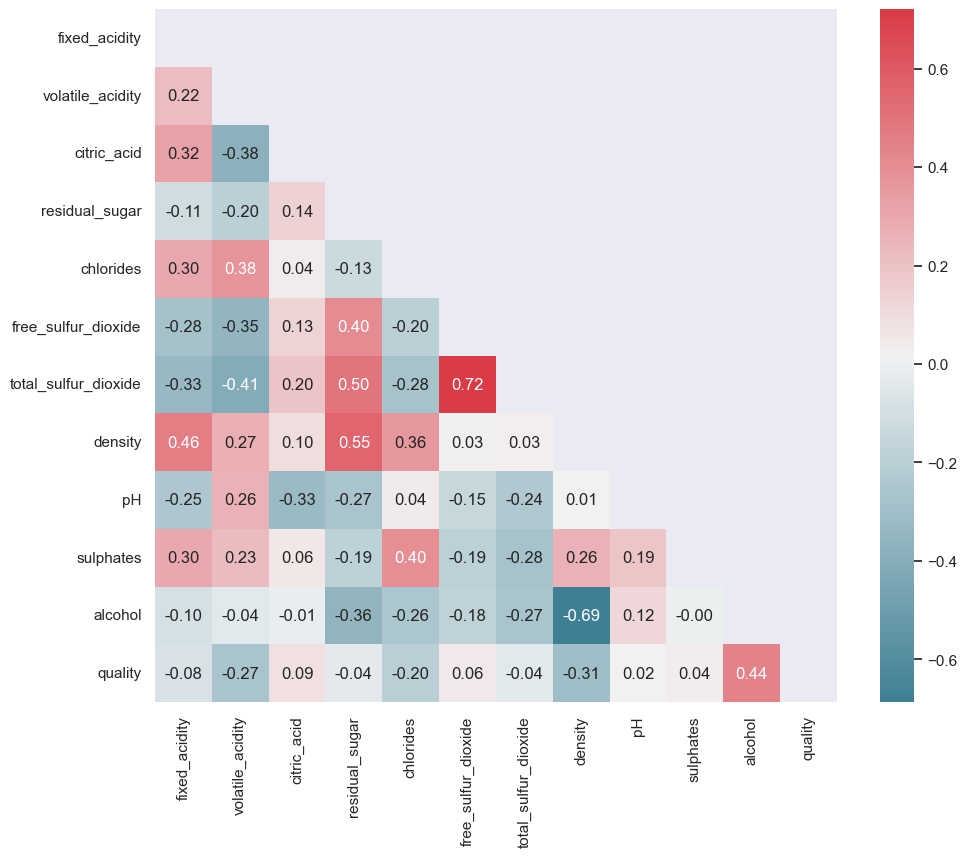

In [63]:
plt.figure(figsize=(11,9))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=1.5);

 #### Distribution  of Variables

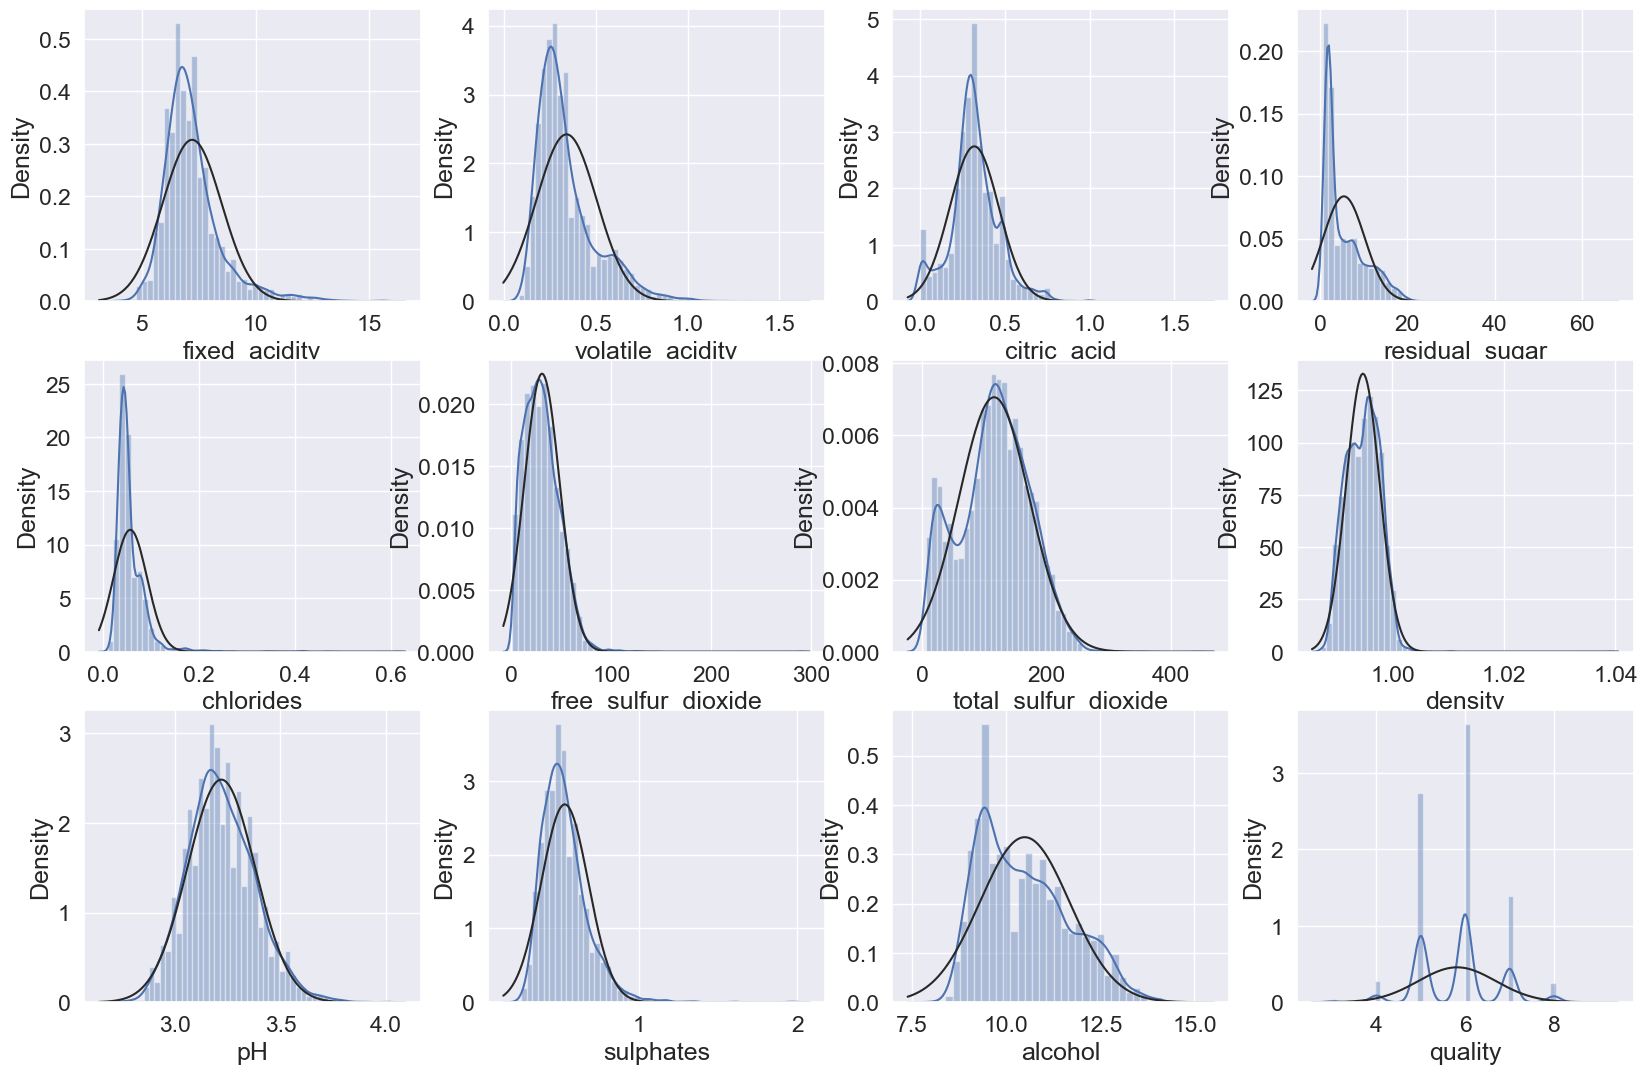

In [57]:
plt.figure(figsize = (20,22))
sns.set(font_scale=1.5)
for i in range(1,13):
    plt.subplot(5,4,i)
    sns.distplot(df[df.columns[i]], fit=norm)

#### Creating 2 Bins Model of Two Types of Wine Quality Classes

In [13]:
df_bins= df.copy()

In [14]:
bins = [0,5,10]
labels = [0, 1] # 'low'=0, 'high'=1
df_bins['quality_range']= pd.cut(x=df_bins['quality'], bins=bins, labels=labels)
print(df_bins[['quality_range','quality']].head(5))
df_bins = df_bins.drop('quality', axis=1)

  quality_range  quality
0             1        6
1             1        6
2             1        6
3             1        6
4             1        6


In [15]:
df_bins

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_range
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,1
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0


#### Quality in  Different Wine Types

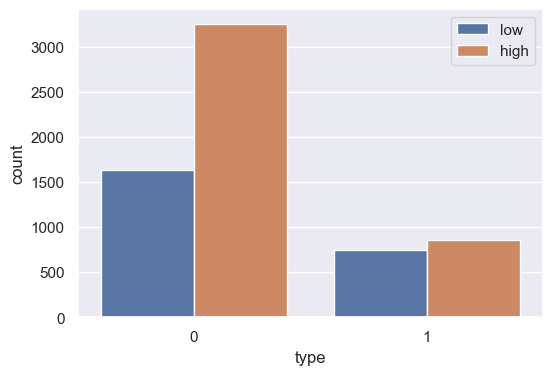

In [70]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'type', hue = 'quality_range', data = df_bins)
sns.set(font_scale=1)
plt.legend(['low', 'high'])
plt.show()
# 'low'=0, 'high'=1

As we see on the chart, Low quality red wine has the highest numerical value in data set as well as low quality white wine. 
High quality white and red wines have little place in data. 

#### Quality & Alcohol Relation 

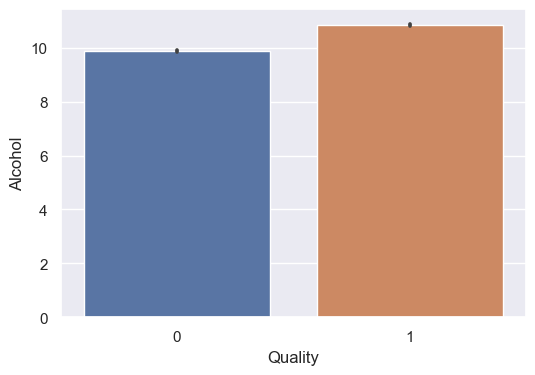

In [76]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_bins, x='quality_range',y='alcohol')
sns.set(font_scale=1)
plt.xlabel('Quality',size=12)
plt.ylabel('Alcohol', size =12)
plt.show()

Red and White wines has similar results on the chart. High quality wines are mostly red wines and have more alcohol level.

#### Quality & Volatile Acidity by Types

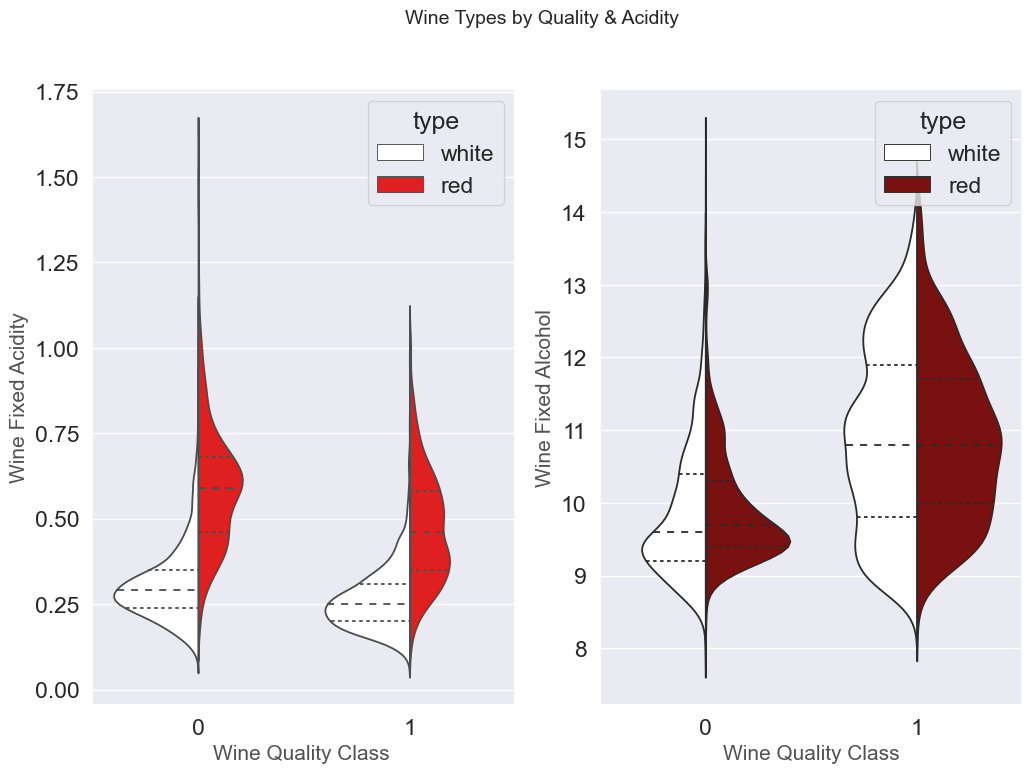

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
f.suptitle('Wine Types by Quality & Acidity', fontsize=14)

sns.violinplot(x='quality_range', y='volatile_acidity', hue='type', data=df_bins, split=True, 
               inner='quart', linewidth=1.3, palette={'red': 'red', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality Class ",size = 15,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 15,alpha=0.8)

sns.violinplot(x='quality_range', y='alcohol', hue='type', data=df_bins, split=True, inner='quart', 
               linewidth=1.3, palette={'red': 'darkred', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 15,alpha=0.8)
ax2.set_ylabel("Wine Fixed Alcohol",size = 15,alpha=0.8)
plt.show()

Fixed acidity level is low in both wine classes, especially in white wine while red wine has more in low quality class up to 1.70.  Fixed alcohol level is again high in red wine class comparing white wine in low quality. High quality class has the highest fixed alcohol level in booth wine classes. 

#### Chlorides Level in Quality Classes 

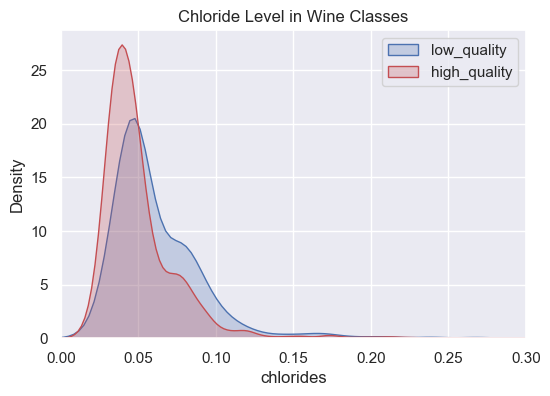

In [83]:
plt.figure(figsize= (6,4))
low_quality = df_bins [df_bins['quality_range']== 0]['chlorides']
high_quality   = df_bins [df_bins['quality_range']== 1][ 'chlorides']
ax = sns.kdeplot(data= low_quality, label= 'low_quality', shade=True, color=None)
ax = sns.kdeplot(data= high_quality,label= 'high_quality',shade=True, color= "r")
sns.set(font_scale=1)
plt.title("Chloride Level in Wine Classes")
plt.xlim(0.0,0.3)
plt.legend()
plt.show()

Chloride Level is a bit higher in red wine in contrats with white wine. 

#### Fixed Acidity & Volatile Acidity & Citric Acid Density in Quality Classes

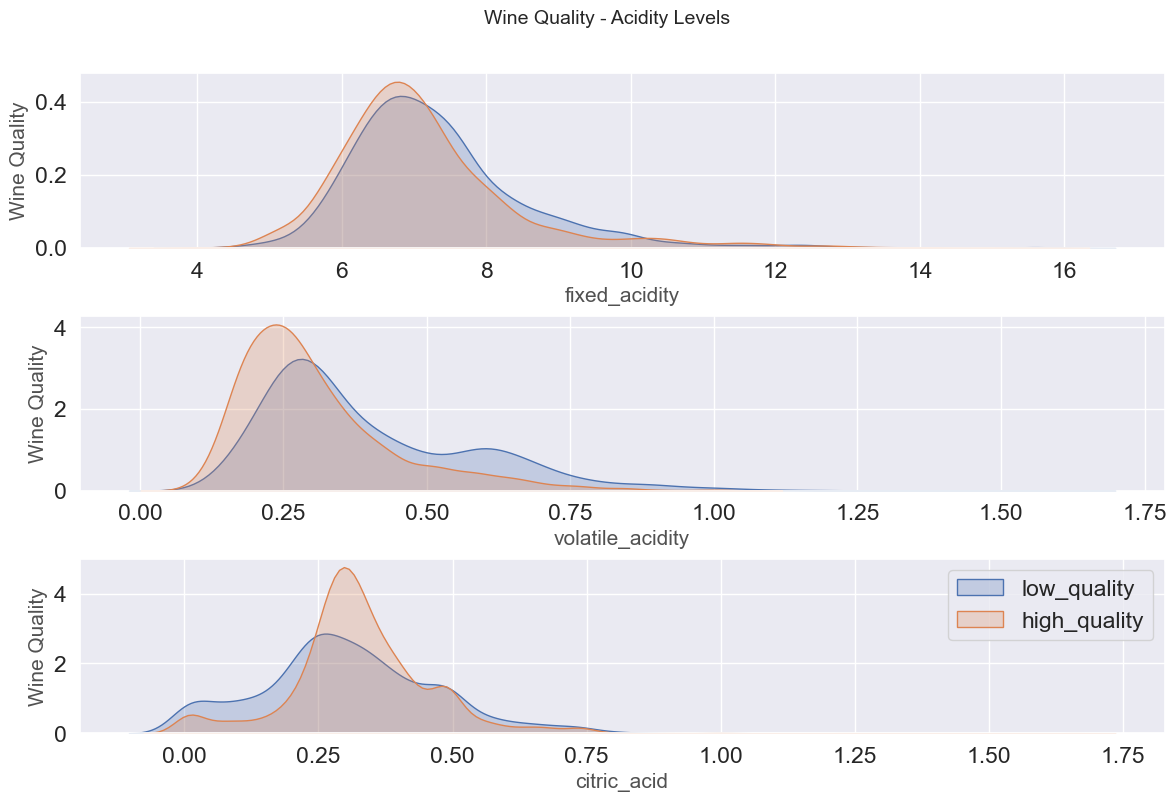

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = (12,8))
f.suptitle('Wine Quality - Acidity Levels', fontsize=14)
f.tight_layout()

fixed_acidity_low_quality    = df_bins [df_bins['quality_range']== 0]['fixed_acidity']
fixed_acidity_high_quality   = df_bins [df_bins['quality_range']== 1]['fixed_acidity']

volatile_acidity_low_quality = df_bins [df_bins['quality_range']== 0]['volatile_acidity']
volatile_acidity_high_quality= df_bins [df_bins['quality_range']== 1]['volatile_acidity']

citric_acid_low_quality      = df_bins [df_bins['quality_range']== 0]['citric_acid']
citric_acid_high_quality     = df_bins [df_bins['quality_range']== 1]['citric_acid']

sns.kdeplot(data=fixed_acidity_low_quality, label="low_quality", shade=True,ax=ax1)
sns.kdeplot(data=fixed_acidity_high_quality, label="high_quality", shade=True, ax=ax1)
ax1.set_xlabel("fixed_acidity",size = 15,alpha=0.8)
ax1.set_ylabel("Wine Quality",size = 15,alpha=0.8)

sns.kdeplot(data=volatile_acidity_low_quality, label="low_quality", shade=True,ax=ax2)
sns.kdeplot(data=volatile_acidity_high_quality, label="high_quality", shade=True, ax=ax2)
ax2.set_xlabel("volatile_acidity",size = 15,alpha=0.8)
ax2.set_ylabel("Wine Quality",size = 15,alpha=0.8)

sns.kdeplot(data=citric_acid_low_quality, label="low_quality", shade=True,ax=ax3)
sns.kdeplot(data=citric_acid_high_quality, label="high_quality", shade=True, ax=ax3)
ax3.set_xlabel("citric_acid",size = 15,alpha=0.8)
ax3.set_ylabel("Wine Quality",size = 15,alpha=0.8)

plt.legend()
plt.show()

#### Residual Sugar Levels by Wine Quality Classes

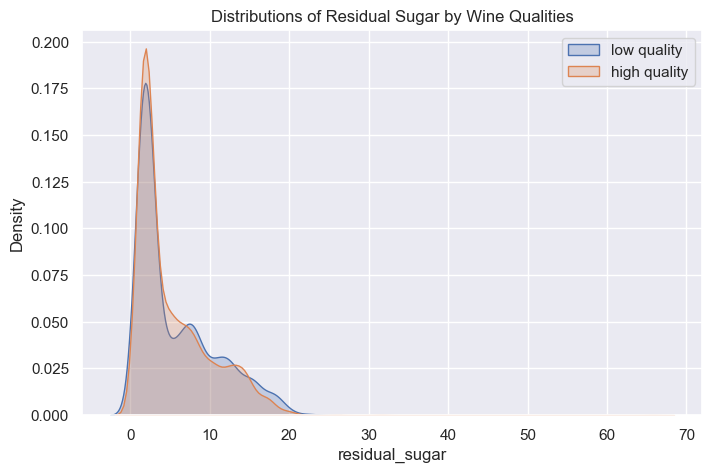

In [86]:
plt.figure(figsize=(8,5))
residual_sugar_low   = df_bins [df_bins['quality_range']== 0]['residual_sugar']
residual_sugar_high  = df_bins [df_bins['quality_range']== 1]['residual_sugar'] 
ax = sns.kdeplot(data= residual_sugar_low, label= 'low quality', shade=True)
ax = sns.kdeplot(data= residual_sugar_high,   label= 'high quality', shade=True)
sns.set(font_scale=1)
plt.title("Distributions of Residual Sugar by Wine Qualities")
plt.legend()
plt.show()

#### Sulfur Dioxide Distribution in Wine Quality Classes

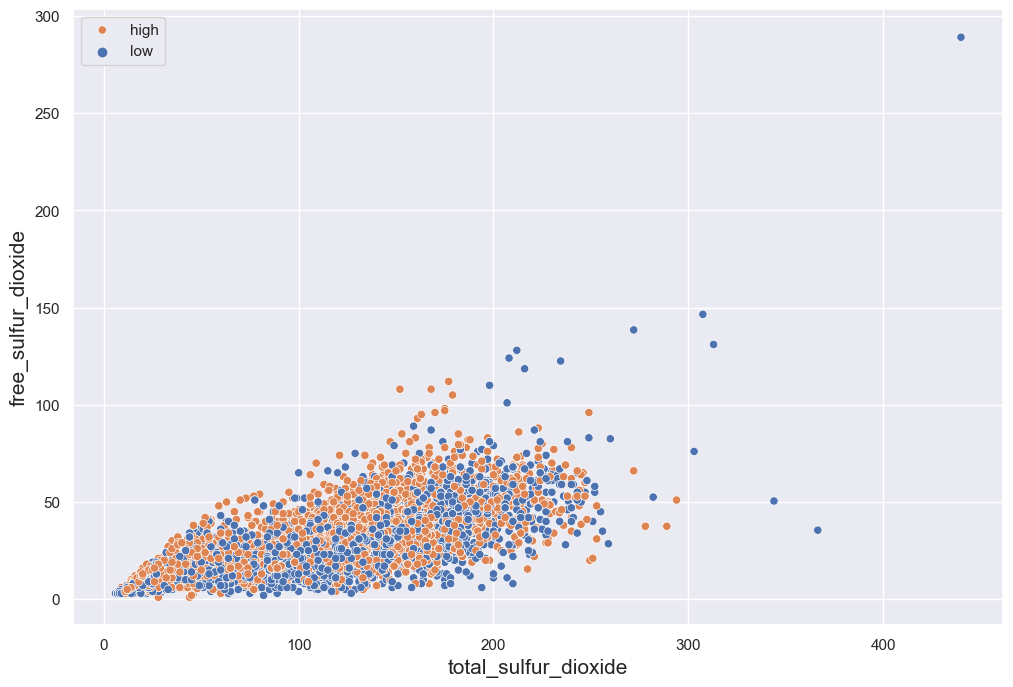

In [88]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='total_sulfur_dioxide', y='free_sulfur_dioxide', hue='quality_range',data=df_bins);
plt.xlabel('total_sulfur_dioxide',size=15)
plt.ylabel('free_sulfur_dioxide', size =15)
sns.set(font_scale=1)
plt.legend(['high','low']);

There are some extreme values in low quality wine class. Total sulfur dioxide level is getting higher in some low quality wine class while general disturubution is standing up to 100 level of free sulfur dioxide.   

#### pH Level in Wine Quality

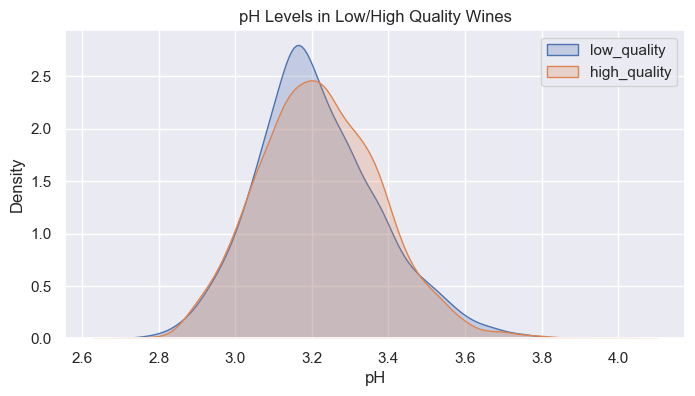

In [90]:
plt.figure(figsize=(8,4))
pH_low_quality  = df_bins [df_bins['quality_range']== 0]['pH']
pH_high_quality = df_bins [df_bins['quality_range']== 1][ 'pH']
ax = sns.kdeplot(data= pH_low_quality, label= 'low_quality', shade=True) 
ax = sns.kdeplot(data= pH_high_quality,label= 'high_quality',   shade=True)
sns.set(font_scale=1)
plt.title("pH Levels in Low/High Quality Wines")
plt.xlabel('pH')
plt.legend()
plt.show()

#### Density by Wine Quality Classes

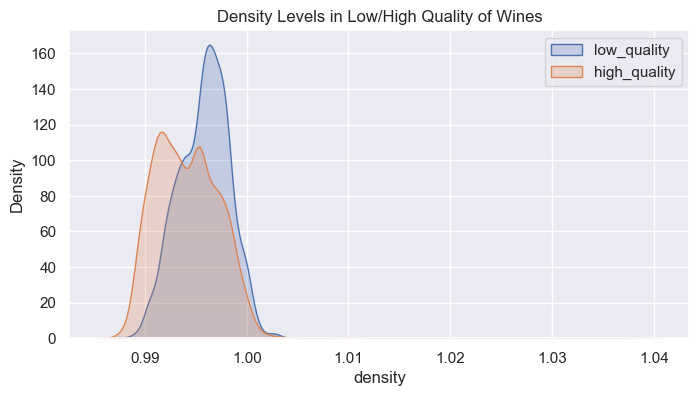

In [92]:
plt.figure(figsize=(8,4))
density_low_quality  = df_bins [df_bins['quality_range']== 0]['density']
density_high_quality = df_bins [df_bins['quality_range']== 1][ 'density']
ax = sns.kdeplot(data= density_low_quality, label= 'low_quality', shade=True) 
ax = sns.kdeplot(data= density_high_quality,label= 'high_quality', shade=True)
sns.set(font_scale=1)
plt.title("Density Levels in Low/High Quality of Wines")
plt.xlabel('density')
plt.legend()
plt.show()

#### Sulphate Values in Wine Quality Classes

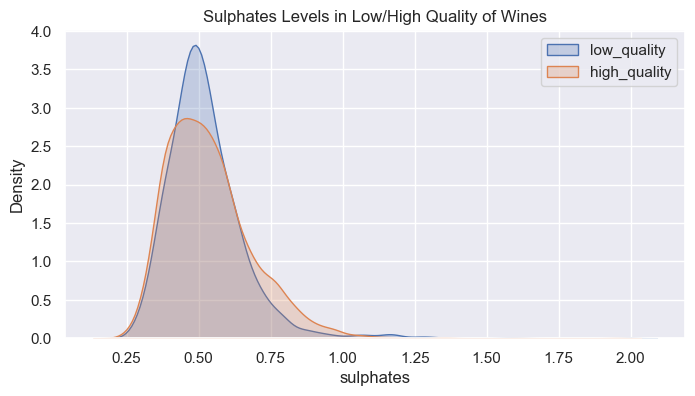

In [93]:
plt.figure(figsize=(8,4))

sulphates_low_quality    = df[df_bins['quality_range']== 0]['sulphates']
sulphates_high_quality   = df[df_bins['quality_range']== 1][ 'sulphates']
ax = sns.kdeplot(data= sulphates_low_quality, label= 'low_quality',  shade=True) 
ax = sns.kdeplot(data= sulphates_high_quality,label= 'high_quality', shade=True)
sns.set(font_scale=1)
plt.title("Sulphates Levels in Low/High Quality of Wines")
plt.xlabel('sulphates')
plt.legend()
plt.show()

There is more low quality wine in between 0.4 and 0.6 levels of sulphate levels. Both quality classes have similar values.

#### Overview about Outliers

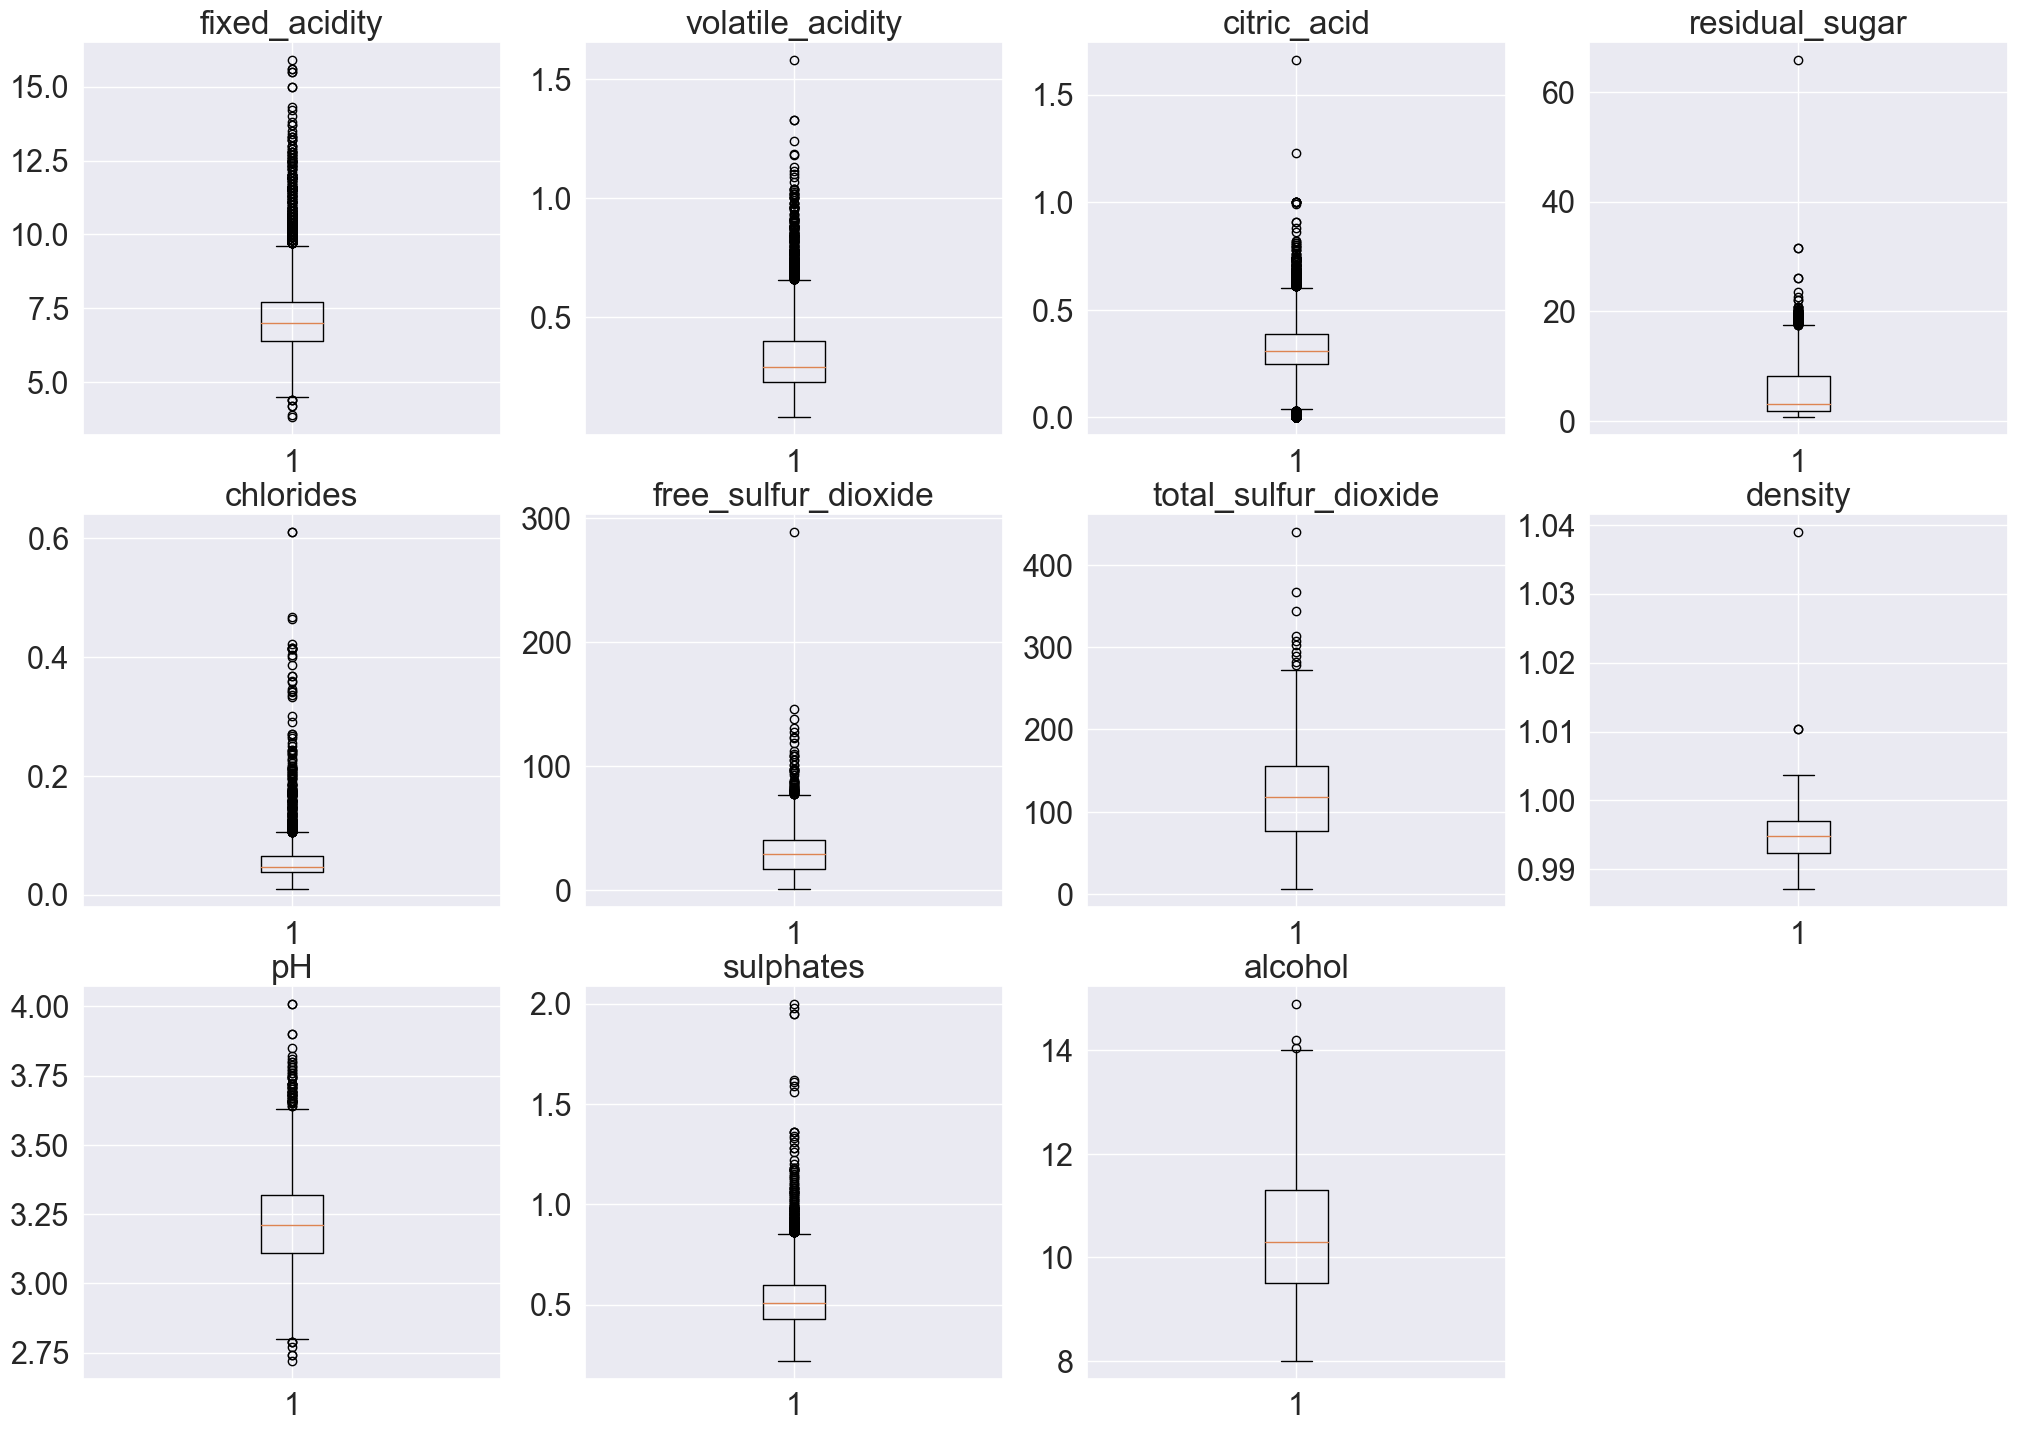

In [125]:
outliers_by_12_variables = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
                            'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                            'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
sns.set(font_scale=2)
plt.figure(figsize=(22,20))
for i in range(0,11):
    plt.subplot(5, 4, i+1)
    plt.subplots_adjust(right=1, top=1.25)
    plt.boxplot(df_bins[outliers_by_12_variables[i]])
    plt.title(outliers_by_12_variables[i])

#### Winsorization

In [27]:
def winsor(x, multiplier=3): 
    upper= x.median() + x.std()*multiplier
    for limit in np.arange(0.001, 0.20, 0.001):
        if np.max(winsorize(x,(0,limit))) < upper:
            return limit
    return None 

In [28]:
kolon_isimleri = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 
                  'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 
                  'pH', 'sulphates', 'alcohol']
for i in range(1,len(kolon_isimleri)):
    df_bins[kolon_isimleri[i]] = winsorize(df_bins[kolon_isimleri[i]], (0, winsor(df_bins[kolon_isimleri[i]])))

# 3. Data Preparation

In [29]:
def null_cell(df): 
    total_missing_values = df.isnull().sum() 
    missing_values_per = df.isnull().sum()/df.isnull().count() 
    null_values = pd.concat([total_missing_values, missing_values_per], axis=1, keys=['total_null', 'total_null_perc']) 
    null_values = null_values.sort_values('total_null', ascending=False) 
    return null_values[null_values['total_null'] > 0] 

In [30]:
null_cell(df)

,total_null,total_null_perc
fixed_acidity,10,0.001539
pH,9,0.001385
volatile_acidity,8,0.001231
sulphates,4,0.000616
citric_acid,3,0.000462
residual_sugar,2,0.000308
chlorides,2,0.000308


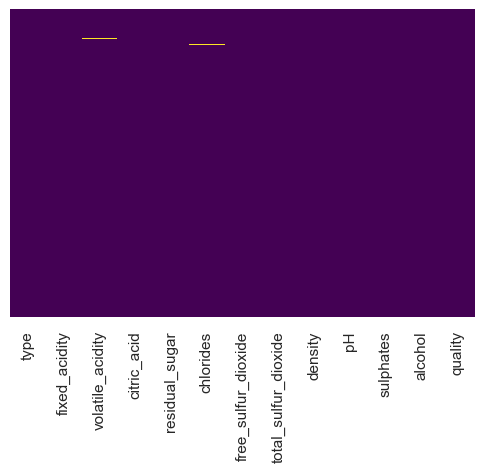

In [128]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
sns.set(font_scale=1);

In [32]:
fill_list = (null_cell(df)).index

In [33]:
df_mean = df.copy()
for col in fill_list:
    df_mean.loc[:, col].fillna(df_mean.loc[:, col].mean(), inplace=True)

In [34]:
null_cell(df_mean)

,total_null,total_null_perc


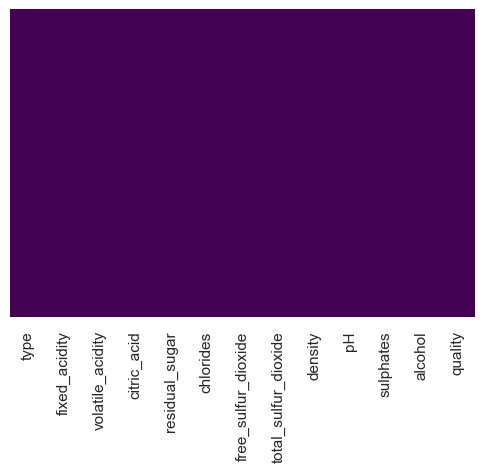

In [130]:
sns.heatmap(df_mean.isnull(),yticklabels=False,cbar=False,cmap='viridis')
sns.set(font_scale=1);

Wine quality has the highest correlation with alcohol. Other relation degrees are very low with each other,such as citric acid,free_sulfur_dioxide, sulphates and pH. Quality also has a low negative correlation with density,volatile acidity, chlorides, total_sulfur_dioxide and residual_sugar.

# 4. Modeling

#### Creating Train / Test Groups with 2 Bins Model
In order to have all variables in numeric data, I mapped wine types as following by using the previous data frame 'df_bins':

In [45]:
df_bins= df_mean.copy()
bins = [0,5,10]
labels = [0, 1] # 'low'=0, 'high'=1
df_bins['quality_range']= pd.cut(x=df_bins['quality'], bins=bins, labels=labels)
print(df_bins[['quality_range','quality']].head(5))
df_bins = df_bins.drop('quality', axis=1) 

  quality_range  quality
0             1        6
1             1        6
2             1        6
3             1        6
4             1        6


In [46]:
df_bins.type = df_bins.type.map({'white':0, 'red':1})

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

In [48]:
X = df_bins[['type', 'alcohol', 'density', 'volatile_acidity', 'chlorides',
       'citric_acid', 'fixed_acidity', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'sulphates', 'residual_sugar', 'pH']] 
y = df_bins.quality_range
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=40)

#### LogisticRegression

In [49]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)

LogisticRegression(random_state=40)

In [50]:
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)
print('One-vs-rest', '-'*35, 
      'Accuracy in Train Group   : {:.2f}'.format(train_accuracy), 
      'Accuracy in Test  Group   : {:.2f}'.format(test_accuracy), sep='\n')

One-vs-rest
-----------------------------------
Accuracy in Train Group   : 0.74
Accuracy in Test  Group   : 0.73


# 5. Evaluation

#### Confusion Matrix in Chart

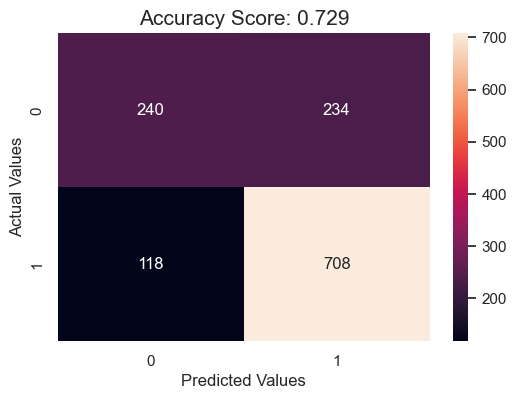

In [132]:
from sklearn.metrics import confusion_matrix as cm

predictions = lr.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
sns.set(font_scale=1)
plt.show()

In [133]:
pred_test  = lr.predict(X_test)
pred_train = lr.predict(X_train)

#### Confusion Matrix in array format

In [134]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test,pred_test)
cm

array([[240, 234],
       [118, 708]], dtype=int64)

#### Performance Measurements

In [135]:
quality_pred = LogisticRegression(random_state=40)
quality_pred.fit(X_train,y_train)

LogisticRegression(random_state=40)

In [136]:
confusion_matrix_train = confusion_matrix(y_train,pred_train)
confusion_matrix_test = confusion_matrix(y_test,pred_test)

print('Confusion Matrix Train Data', '--'*20, confusion_matrix_train, sep='\n')
print('Confusion Matrix Test Data', '--'*20, confusion_matrix_test, sep='\n')

Confusion Matrix Train Data
----------------------------------------
[[1026  884]
 [ 485 2802]]
Confusion Matrix Test Data
----------------------------------------
[[240 234]
 [118 708]]


In [137]:
TN = confusion_matrix_test[0][0]
TP = confusion_matrix_test[1][1]
FP = confusion_matrix_test[0][1]
FN = confusion_matrix_test[1][0]

print("(Total) True Negative       :", TN)
print("(Total) True Positive       :", TP)
print("(Total) Negative Positive   :", FP)
print("(Total) Negative Negative   :", FN)

(Total) True Negative       : 240
(Total) True Positive       : 708
(Total) Negative Positive   : 234
(Total) Negative Negative   : 118


It is better to check FP and FN values for another deep study to focus on false predictions for a better target of accurancy and results.  
A new data set can be created with predictions, X_test and y_test data, than we can check for prediction value of this seperate data set. 

#### Accuracy

In [138]:
from sklearn.metrics import accuracy_score
print("Accuracy Score of Our Model     : ",  quality_pred.score(X_test, y_test))

Accuracy Score of Our Model     :  0.7292307692307692


#### Error Rate

In [139]:
Error_Rate = 1 - (accuracy_score(y_test, pred_test))  
Error_Rate

0.27076923076923076

#### Precision
Out of all the predicted positive instances, how many were predicted correctly TP / (TP + FP) ) 


In [140]:
from sklearn.metrics import precision_score
print("precision_score()         : ",  precision_score(y_test, pred_test, average='micro'))

precision_score()         :  0.7292307692307692


####  Recall 
Out of all the positive classes, how many instances were identified correctly TP / (TP + FN) 

In [141]:
from sklearn.metrics import recall_score
print("recall_score()            : ",  recall_score(y_test, pred_test, average='micro'))

recall_score()            :  0.7292307692307692


#### Specificity
It informs us about the proportion of actual negative cases that have gotten predicted as negative TN / (TN + FP) 

In [142]:
print(" Specificity Score   : ",  (TN)/(TN + FP)) 

 Specificity Score   :  0.5063291139240507


#### F1-Score 
From Precision and Recall, F-Measure is computed and used as metrics sometimes. F – Measure is nothing but the harmonic mean of Precision and Recall 2 * ((Recall * Precision) / (Recall + Precision))

In [143]:
from sklearn.metrics import f1_score
precision_s = precision_score(y_test, pred_test,average='micro')
recall_s    = recall_score(y_test, pred_test, average='micro')
print("F1_score     : ",  2*((precision_s*recall_s)/(precision_s + recall_s)))

F1_score     :  0.7292307692307691


In [144]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(y_test,pred_test))
print("f1_score        : {:.2f}".format(f1_score(y_test, pred_test, average='micro')))
print("recall_score    : {:.2f}".format(recall_score(y_test, pred_test, average='micro')))
print("precision_score : {:.2f}".format(precision_score(y_test, pred_test, average='micro')))
print('\n')
metrics =  precision_recall_fscore_support(y_test, pred_test)
print("Precision       :" , metrics[0]) 
print("Recall          :" , metrics[1]) 
print("F1 Score        :" , metrics[2]) 

              precision    recall  f1-score   support

           0       0.67      0.51      0.58       474
           1       0.75      0.86      0.80       826

    accuracy                           0.73      1300
   macro avg       0.71      0.68      0.69      1300
weighted avg       0.72      0.73      0.72      1300

f1_score        : 0.73
recall_score    : 0.73
precision_score : 0.73


Precision       : [0.67039106 0.75159236]
Recall          : [0.50632911 0.85714286]
F1 Score        : [0.57692308 0.80090498]


#### ROC/AUC(Area Under Curve)

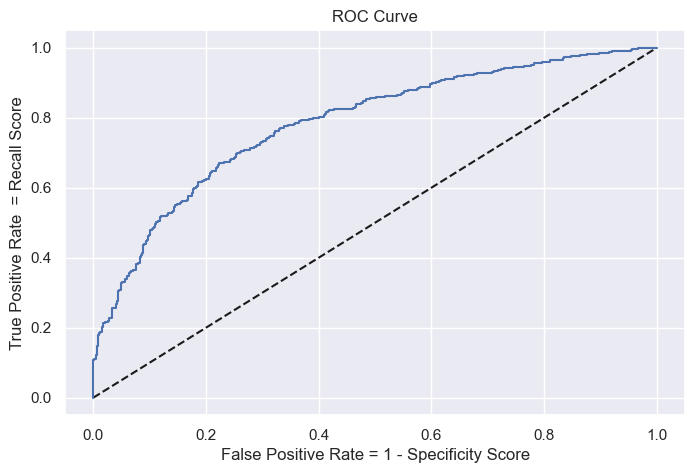

In [145]:
probs = quality_pred.predict_proba(X_test)[:,1]  #Predict probabilities for the test data

fpr, tpr, thresholds  = roc_curve(y_test, probs) #Get the ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()

In [146]:
print('AUC: ', roc_auc_score(y_test.values, probs))

AUC:  0.7840770936136737


#### PRECISION RECALL CURVE 
(The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.)

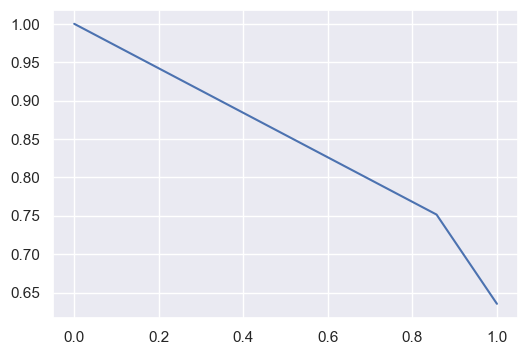

In [148]:
precision, recall, _ = precision_recall_curve(y_test, pred_test)
plt.plot(recall, precision)
plt.show()

#### Log Loss 
Calculating the difference between ground truth and predicted score for every observation and average those errors over all observations

In [147]:
from sklearn.metrics import log_loss
print("Log-Loss)    : " , log_loss(y_test.values, probs))
print("Error Rate   : " , 1- accuracy_score(y_test.values, pred_test))

Log-Loss)    :  0.5328509332226015
Error Rate   :  0.27076923076923076


#### General Looking at Results

In [149]:
C_values = [0.001,0.01,0.1,1,10,100, 1000]
accuracy_df = pd.DataFrame(columns = ['C_values','Accuracy'])
accuracy_values = pd.DataFrame(columns=['C Value', 'Accuracy Train', 'Accuracy Test'])
for c in C_values:
# Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = c, random_state = 0)
    lr.fit(X_train,y_train)
    accuracy_values = accuracy_values.append({'C Value': c,
                                                    'Accuracy Train' : lr.score(X_train, y_train),
                                                    'Accuracy Test': lr.score(X_test, y_test)
                                                    }, ignore_index=True)
display(accuracy_values)

,C Value,Accuracy Train,Accuracy Test
0,0.001,0.663845,0.651538
1,0.010,0.693285,0.671538
2,0.100,0.727535,0.723077
3,1.000,0.736579,0.729231
4,10.000,0.735232,0.726154
5,100.000,0.732346,0.723077
6,1000.000,0.730806,0.715385


#### Conclusion


In the beginning of this study, I checked general characteristic of the data set. Data has some NULL values. Even though, dropping missing values is still an option due to low percentage of missing values in data, I preferred to filled them by the mean of data. 

Data set shows that red wine is very reach in wine quality with a high correlation with alcohol. 

I also looked at quality levels in each variable by using suitable charts for a general understanding.  

This study only shows the best model with good scores and predictions.

The first model was included 2 bins with all variables in a quality range of 0-5,5-10. This model gives %0.74 accuracy score on train and test samples. 

Generally, our measurements and model scores worked well to show the aim of the study. This study can be completed in a shorter way as well without repeating similar functions; however, this study also aims to use different methods to have accurate scores from variable sources. 

I focused on classification methods on this study. However, I agree that other algorithms can be more successful such as Random forest and Boosting algorithms give better results. I will use these methods in my next kernel.


# 6. Deployment
Its not available now, but it's included in way forward plan.